In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

from sklearn.utils import check_array

from scikeras.wrappers import KerasClassifier, KerasRegressor

from sklearn.model_selection import GridSearchCV

In [16]:
# Đọc dữ liệu từ tệp CSV
data = pd.read_csv(r'D:\STB.csv')

In [17]:
# Xử lý dữ liệu
prices = data['Price']

In [18]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices.values.reshape(-1, 1))

In [19]:
# Chia dữ liệu thành tập train test
np.random.seed(42)

train_size = int(len(scaled_prices) * 0.7)
test_size = int(len(scaled_prices) * 0.3)

train_data = scaled_prices[:train_size]
test_data = scaled_prices[train_size:train_size+test_size]

In [20]:
# Chia dữ liệu thành các mẫu chuỗi thời gian
def create_time_series(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)


In [21]:
time_steps = 30  # Số ngày quan sát trước để dự đoán ngày tiếp theo #sửa 30 thành 10
X_train, y_train = create_time_series(train_data, time_steps)
X_test, y_test = create_time_series(test_data, time_steps)

In [22]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [23]:
# define FCN model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(time_steps, 1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(1))


In [24]:
# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=64)

# Đánh giá mô hình trên tập kiểm tra
loss = model.evaluate(X_test, y_test)
print('Loss trên tập kiểm tra:', loss)

Epoch 1/100
27/27 [==============================] - 1s 3ms/step - loss: 0.0075
Epoch 2/100
27/27 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 3/100
27/27 [==============================] - 0s 3ms/step - loss: 7.8619e-04
Epoch 4/100
27/27 [==============================] - 0s 3ms/step - loss: 7.8948e-04
Epoch 5/100
27/27 [==============================] - 0s 3ms/step - loss: 7.5773e-04
Epoch 6/100
27/27 [==============================] - 0s 5ms/step - loss: 7.3851e-04
Epoch 7/100
27/27 [==============================] - 0s 3ms/step - loss: 7.3629e-04
Epoch 8/100
27/27 [==============================] - 0s 2ms/step - loss: 7.2385e-04
Epoch 9/100
27/27 [==============================] - 0s 2ms/step - loss: 6.9951e-04
Epoch 10/100
27/27 [==============================] - 0s 3ms/step - loss: 6.9089e-04
Epoch 11/100
27/27 [==============================] - 0s 3ms/step - loss: 7.2315e-04
Epoch 12/100
27/27 [==============================] - 0s 3ms/step - loss: 7.1574e-

In [25]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Tạo biến train, test
train = prices[:train_size]
test = prices[train_size:train_size+test_size]

y_test_pred = model.predict(X_test)
y_test_pred = scaler.inverse_transform(y_test_pred)

n_past = 1
n_days_for_prediction= 30

#create an array of 30 integers starting from last index
predict_period_dates = np.array(range(len(data) + 1,len(data) + 31)).reshape(-1, 1)

print(predict_period_dates)

#Make prediction
prediction1 = model.predict(X_test[-n_days_for_prediction:])

prediction_copies1 = np.repeat(prediction1, prices.shape[0], axis=-1)
predicted_prices = scaler.inverse_transform(prediction_copies1)[:,0]
print(predicted_prices)

23/23 [==============================] - 0s 1ms/step
[[2472]
 [2473]
 [2474]
 [2475]
 [2476]
 [2477]
 [2478]
 [2479]
 [2480]
 [2481]
 [2482]
 [2483]
 [2484]
 [2485]
 [2486]
 [2487]
 [2488]
 [2489]
 [2490]
 [2491]
 [2492]
 [2493]
 [2494]
 [2495]
 [2496]
 [2497]
 [2498]
 [2499]
 [2500]
 [2501]]
1/1 [==============================] - 0s 25ms/step
[20703.121 20702.857 20687.348 20687.285 20651.684 20651.684 20571.648
 20506.398 20227.264 20291.19  20148.627 20163.531 20160.248 20061.56
 20060.992 20051.621 20051.621 20112.777 20103.193 20477.19  20477.19
 20442.17  20372.717 20372.717 20243.81  20199.195 20198.4   20124.092
 20124.092 20119.244]


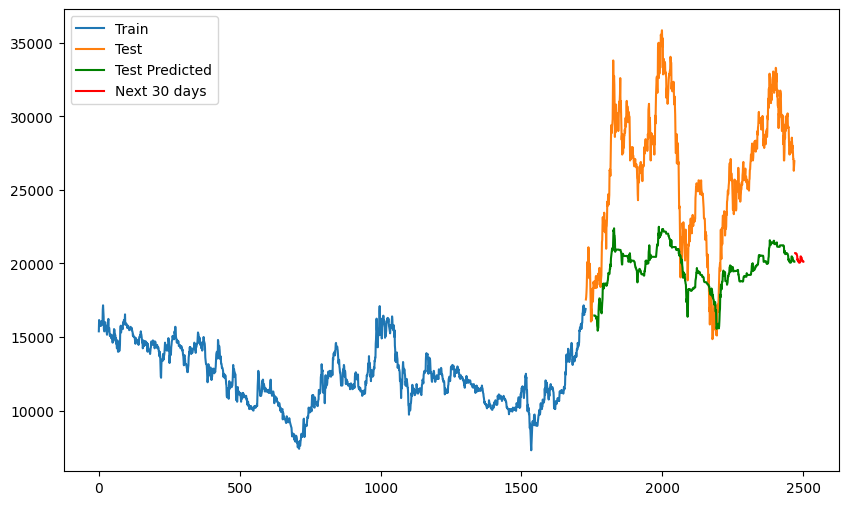

In [26]:
# Tạo biểu đồ train, test và dự đoán 30 ngày tiếp theo
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(range(train_size, train_size + len(test)), test, label='Test')

plt.plot(range(train_size + time_steps,train_size + test_size), y_test_pred, 'g', label='Test Predicted')

plt.plot(predict_period_dates, predicted_prices, 'r', label='Next 30 days')

plt.legend()
plt.show()

In [27]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error

# Dự đoán giá trong quá trình testing
y_test_predicted = model.predict(X_test)

# Đưa các dự đoán về lại tỷ lệ ban đầu
y_test_predicted = scaler.inverse_transform(y_test_predicted)

y_test1 = scaler.inverse_transform(y_test)


# Tính MAE cho testing
mae_test = mean_absolute_error(y_test1, y_test_predicted)

# Tính MAPE cho testing
mape_test = mean_absolute_percentage_error(y_test1, y_test_predicted)

# Tính RMSE cho testing
rmse_test = mean_squared_error(y_test1, y_test_predicted, squared=False)

# Tính MSLE cho testing
msle_test = mean_squared_log_error(y_test1, y_test_predicted, squared=False)




23/23 [==============================] - 0s 1ms/step


In [28]:
mape_test *= 100


print('---------TEST----------')
print("MAPE:", round(mape_test,3))
print("MAE:", round(mae_test,3))
print("RMSE:", round(rmse_test,3))
print("MSLE:", round(msle_test,3))
print('-------------------')


---------TEST----------
MAPE: 24.451
MAE: 6814.327
RMSE: 7463.933
MSLE: 0.305
-------------------
